In [1]:
import os
import pandas as pd
import numpy as np

import plotly.express as px

from nowcastml.prediction import Predictor
from nowcastml.prediction.predictor import build_model_benchmark_df

import nowcastml.prediction.plot as plot
import nowcastml.prediction.transform as trf
from typing import Optional
import temporal_fusion_transformers as tft

import nowcastml.mlops.mlflow_utils as mlflow_utils


os.environ["MLFLOW_TRACKING_URI"] = (
    "https://mlflow-server-med-jupyter-central-dev.apps.dev.ocp.bisinfo.org"
)

ValueError: time data "1950-01" doesn't match format "%Y-%m-%d", at position 19323. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [2]:
parent_id = mlflow_utils.get_most_recent_parent_run_id()
runs = mlflow_utils.get_tft_child_run_df(parent_id)
runs.head()

run_id  experiment_id    status  \
0  ce64a1d4fc9944589af6bc28b806255e              4  FINISHED   
1  ea89d48017004d1ca55eec03e4f21c64              4  FINISHED   
2  9d72f33664874753955206b1f69db1ab              4  FINISHED   
3  069d975898384bef9aed6a81cf8a836f              4  FINISHED   
4  780f87ea9e2d4ff6b47abd9b3fc2aa5c              4  FINISHED   

                                        artifact_uri           start_time  \
0  mlflow-artifacts:/4/ce64a1d4fc9944589af6bc28b8...  1709716288779000000   
1  mlflow-artifacts:/4/ea89d48017004d1ca55eec03e4...  1709709152409000000   
2  mlflow-artifacts:/4/9d72f33664874753955206b1f6...  1709702397605000000   
3  mlflow-artifacts:/4/069d975898384bef9aed6a81cf...  1709688049346000000   
4  mlflow-artifacts:/4/780f87ea9e2d4ff6b47abd9b3f...  1709676891632000000   

              end_time  metrics.rmse_mom_GB  \
0  1709722485242000000             0.181269   
1  1709716288696000000             0.172646   
2  1709709152319000000             0.193254   
3  1709702397521000000             0.214092   
4  1709688049260000000             0.195362   

   metrics.rmse_yoy_JP_1_months_ahead  metrics.rmse_yoy_CH_10_months_ahead  \
0                            0.231095                             0.542196   
1                            0.239373                             0.881367   
2                            0.213163                             0.683915   
3                            0.268683                             0.962746   
4                            0.214461                             0.669168   

   metrics.rmse_yoy_JP_6_months_ahead  ...  params.end_date_train  \
0                            0.612935  ...             2018-01-01   
1                            0.845304  ...             2018-01-01   
2                            0.590022  ...             2018-01-01   
3                            1.105098  ...             2018-01-01   
4                            0.572268  ...             2018-01-01   

   params.learning_rate  params.n_samples  params.d_model  \
0              0.000796               500              28   
1              0.000801               500              43   
2              0.000655               500              45   
3              0.000678               500              45   
4              0.001405               500              53   

                       tags.mlflow.log-model.history  tags.mlflow.user  \
0  [{"run_id": "ce64a1d4fc9944589af6bc28b806255e"...        1000900000   
1  [{"run_id": "ea89d48017004d1ca55eec03e4f21c64"...        1000900000   
2  [{"run_id": "9d72f33664874753955206b1f69db1ab"...        1000900000   
3  [{"run_id": "069d975898384bef9aed6a81cf8a836f"...        1000900000   
4  [{"run_id": "780f87ea9e2d4ff6b47abd9b3fc2aa5c"...        1000900000   

   tags.mlflow.runName  tags.mlflow.source.name  \
0     defiant-flea-334                 train.py   
1    defiant-steed-113                 train.py   
2      clumsy-lark-190                 train.py   
3       aged-chimp-680                 train.py   
4    secretive-mouse-5                 train.py   

            tags.mlflow.parentRunId  tags.mlflow.source.type  
0  705e524ecdcf49b5a0dd190441030f00                    LOCAL  
1  705e524ecdcf49b5a0dd190441030f00                    LOCAL  
2  705e524ecdcf49b5a0dd190441030f00                    LOCAL  
3  705e524ecdcf49b5a0dd190441030f00                    LOCAL  
4  705e524ecdcf49b5a0dd190441030f00                    LOCAL  

[5 rows x 140 columns]

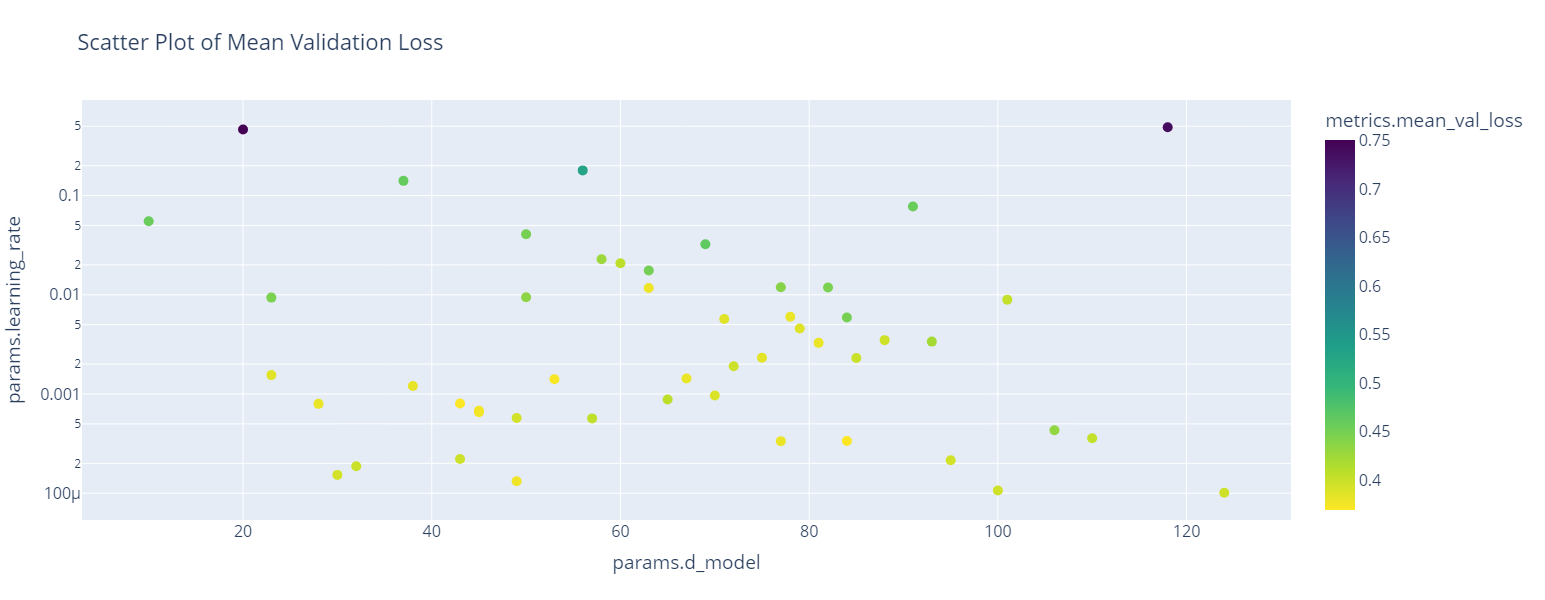

In [3]:
fig = px.scatter(
    runs,
    x="params.d_model",
    y="params.learning_rate",
    color="metrics.mean_val_loss",
    log_y=True,
    title="Scatter Plot of Mean Validation Loss",
    color_continuous_scale=px.colors.sequential.Viridis_r,
    width=1200,
    height=600,
    hover_data=["run_id"],
)
fig.update_traces(marker_size=10)
fig.update_layout(
    font=dict(
        size=16,  # Set the font size here
    )
)

In [4]:
runs = runs[runs["params.learning_rate"] < 0.05]

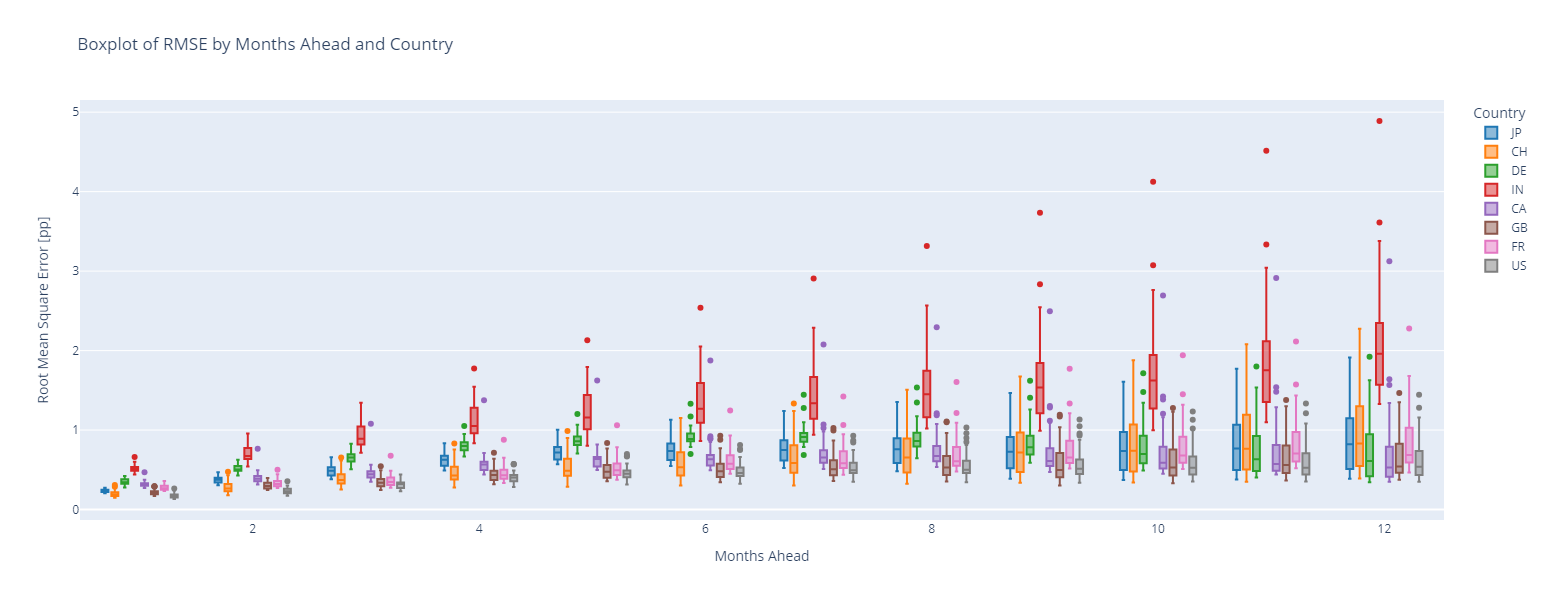

In [5]:
long_df = trf.transform_rmse_box_plot(runs)


# Create a boxplot
fig = px.box(
    long_df,
    x="Months Ahead",
    y="RMSE",
    color="Country",
    color_discrete_sequence=px.colors.qualitative.D3,
    labels={"RMSE": "Root Mean Square Error [pp]"},  # Optional: customizing axis labels
    title="Boxplot of RMSE by Months Ahead and Country",
    width=1200,
    height=600,
)  # Optional: adding a title


# Show the plot
fig.show()

In [6]:
start_date = "2000-01-01"
end_date = "2023-12-01"
model = mlflow_utils.get_best_model(parent_id, metric="metrics.mean_val_loss")
p = Predictor(model, start_date, end_date)

2024/03/11 10:02:22 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - pydantic (current: 1.10.14, required: pydantic==2.6.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024-03-11 10:02:23.558444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38466 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:98:00.0, compute capability: 8.0
/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 

100%|██████████| 1/1 [00:00<00:00, 36.44it/s]
/opt/app-root/src/jupyter_w

In [7]:
df = build_model_benchmark_df(
    p, parent_id, start_date, end_date, tft.countries, [1, 6, 12]
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step


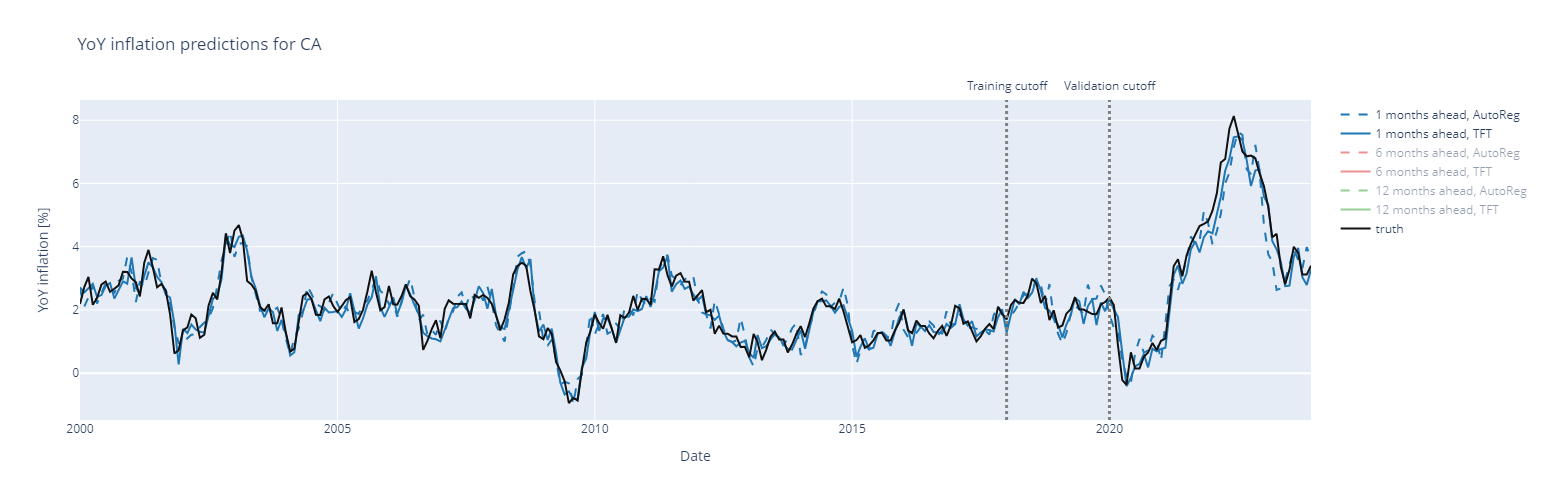

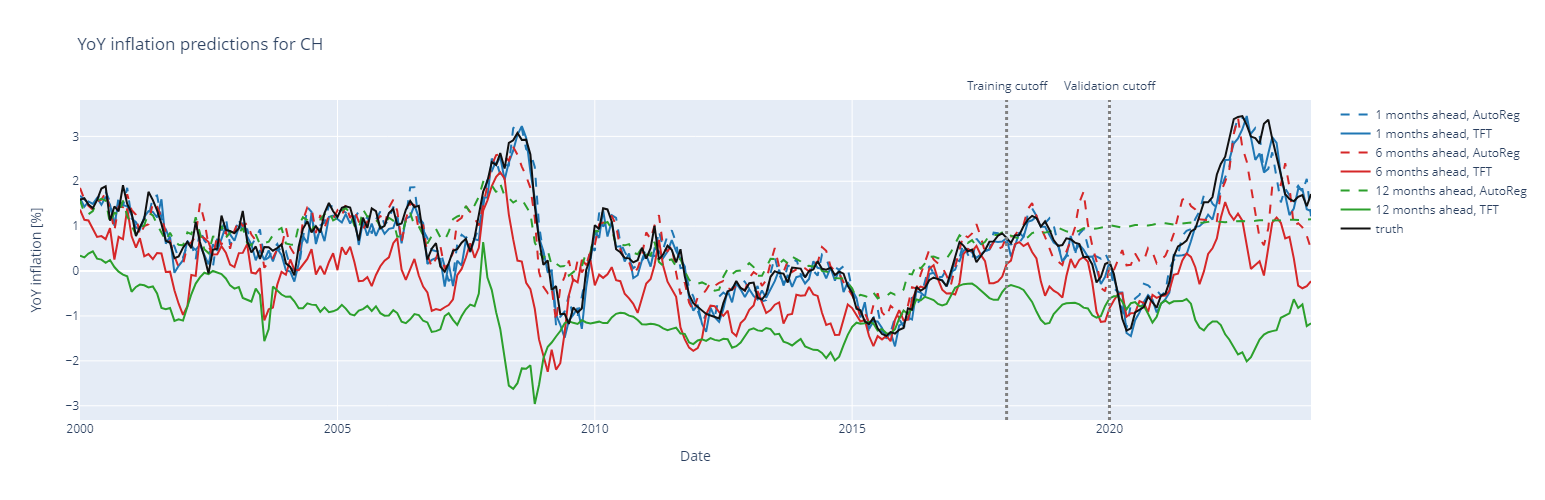

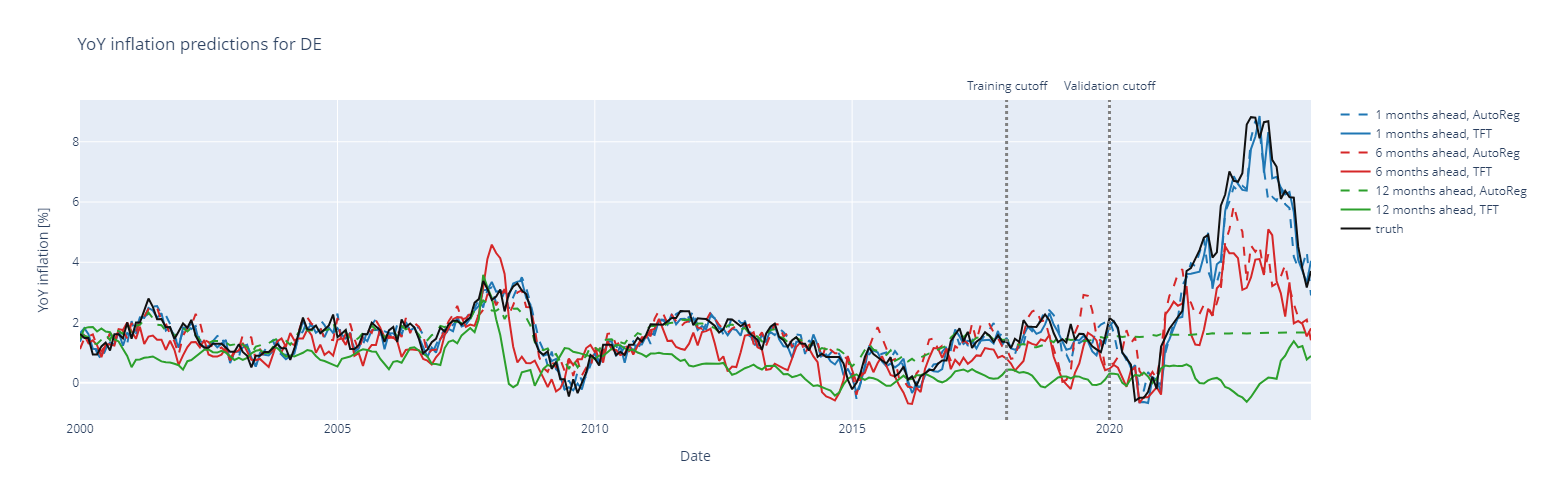

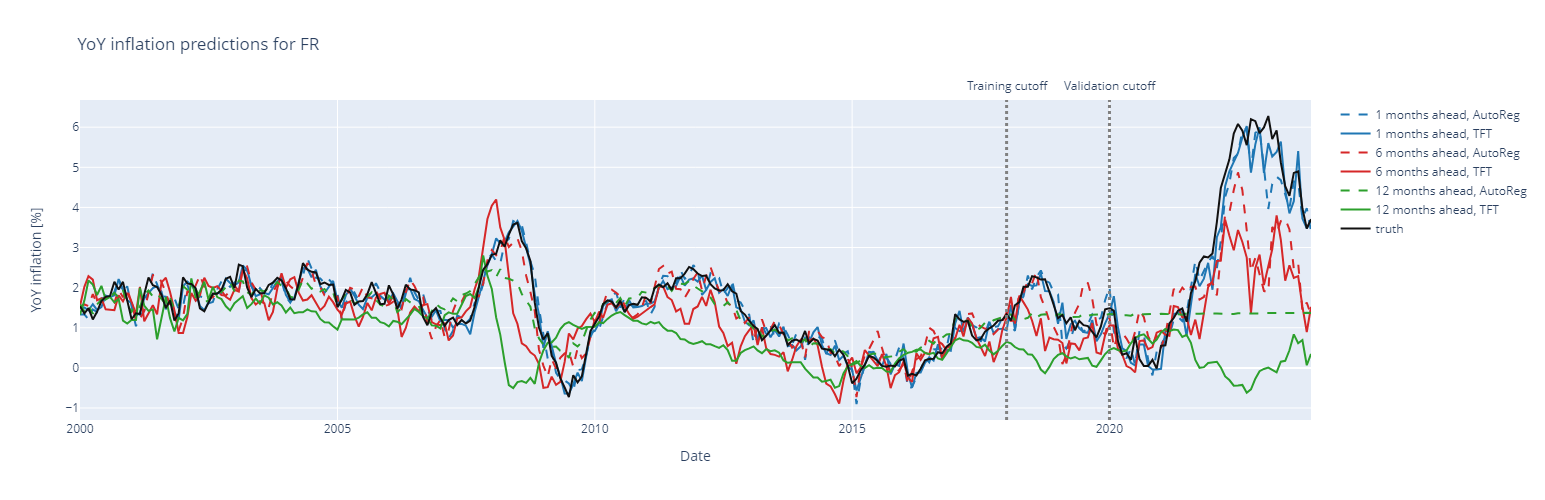

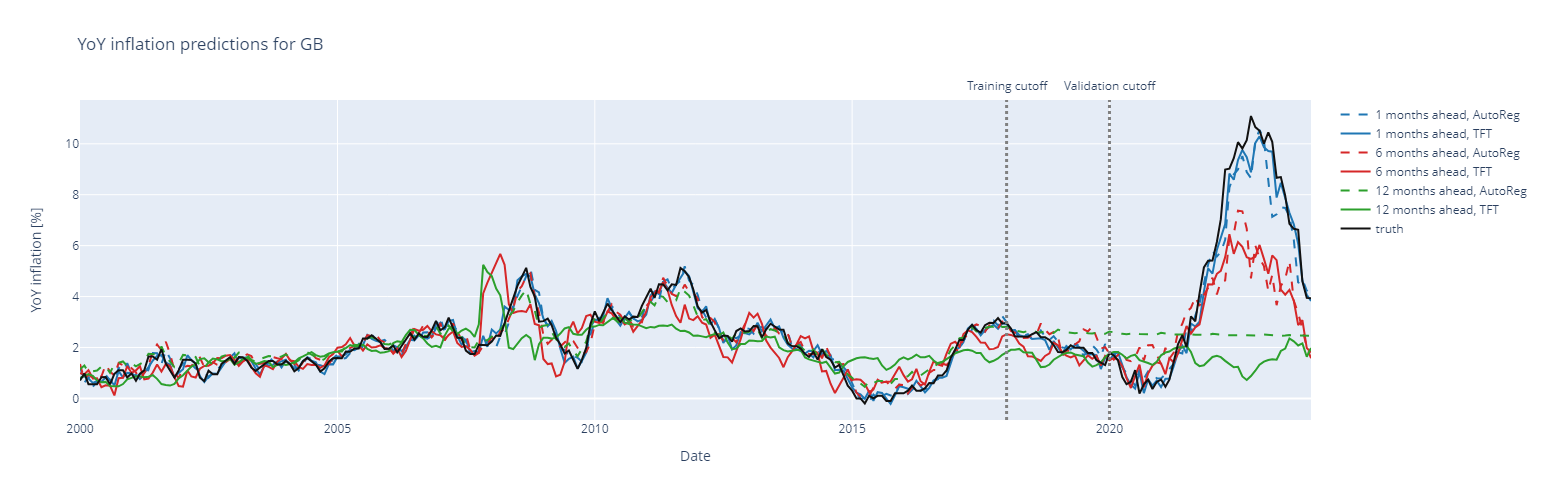

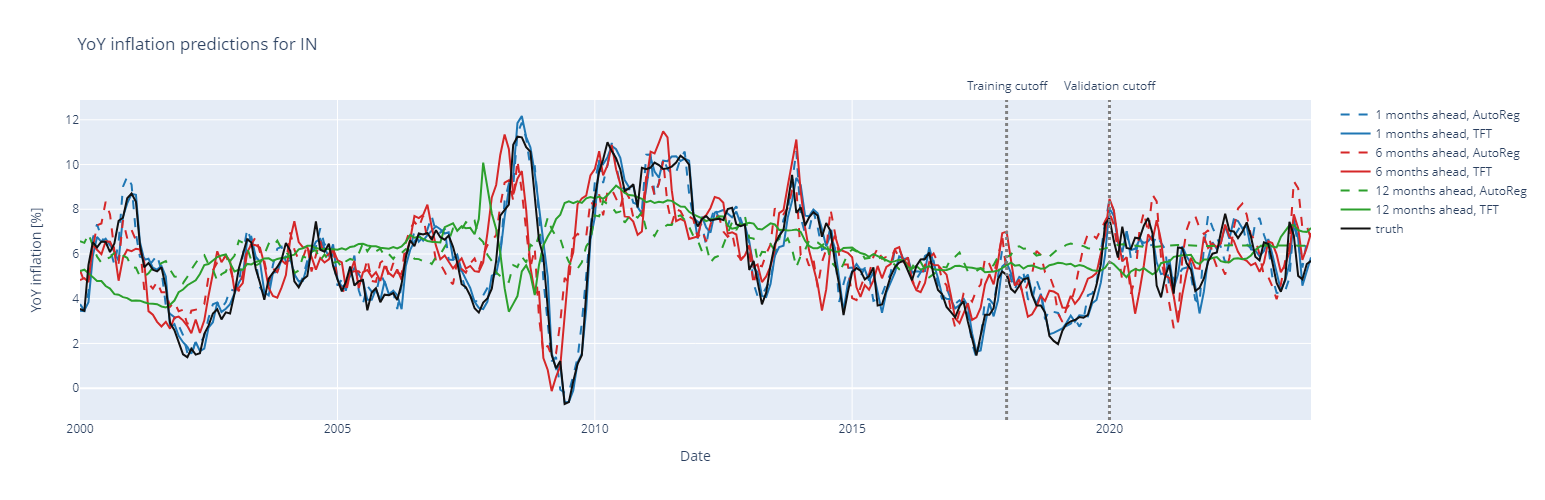

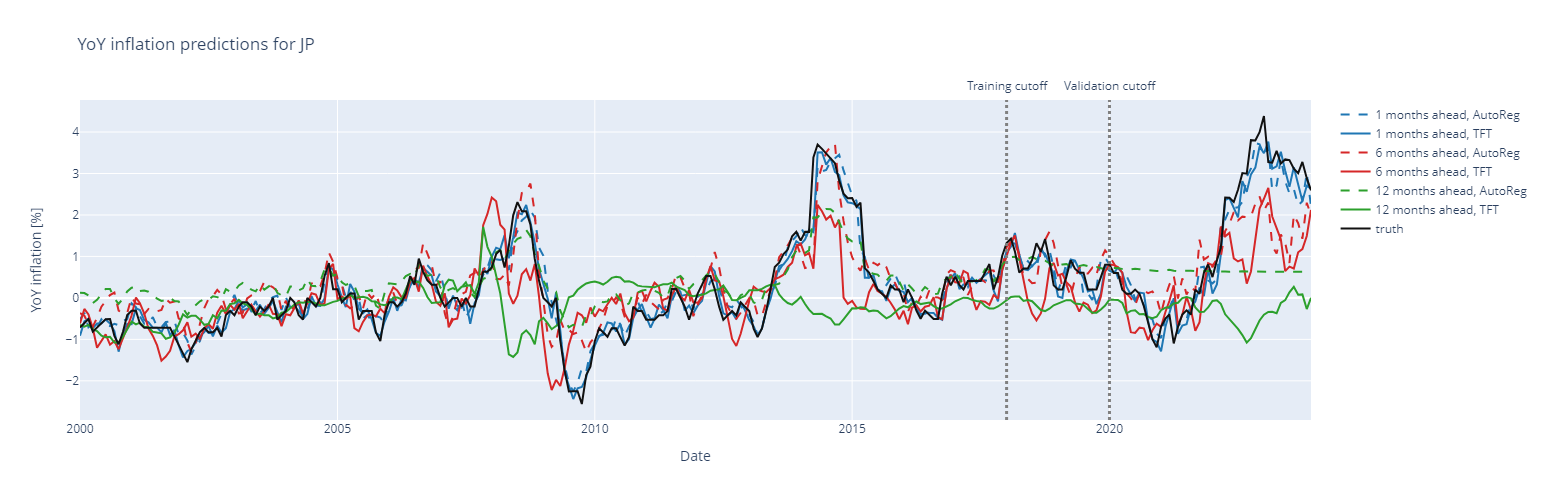

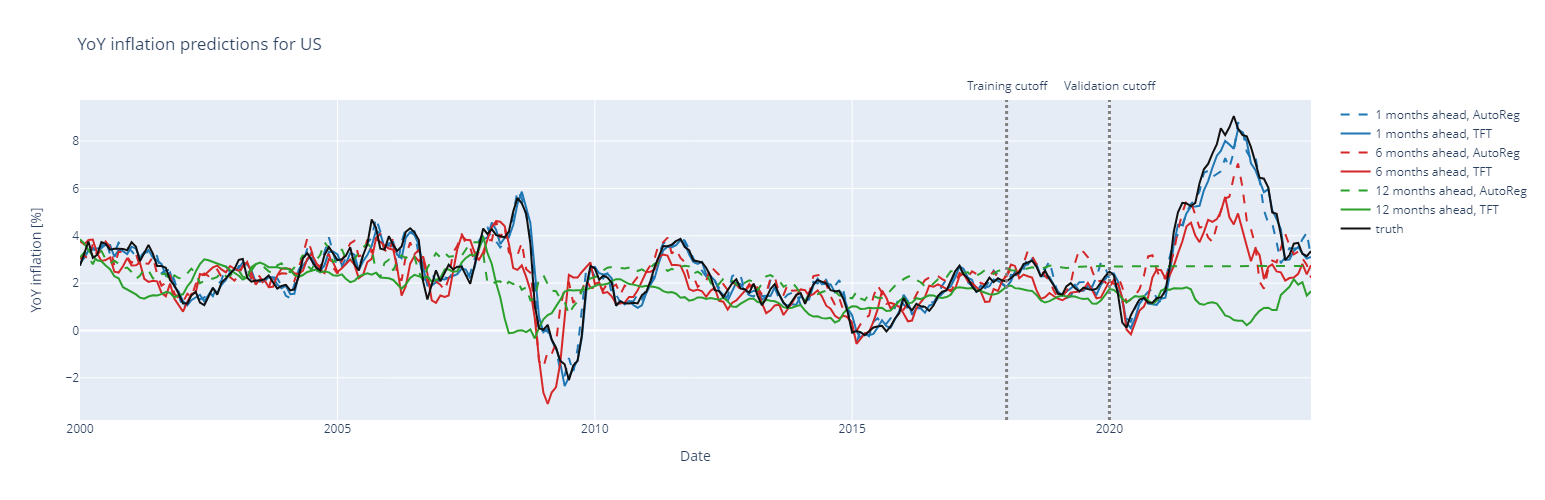

In [8]:
for country in tft.countries:
    fig = plot.plot_prediction_benchmark(df, country, [1, 6, 12])
    fig.show()